# Porovnanie modelov

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score

from sklearn.metrics import roc_curve, roc_auc_score



from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import pickle 


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [3]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [4]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [6]:

Q = training_raw.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_raw.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio), random_state=17),
            training_raw.query('combined_issue_criteria_3y_off == 1').sample(Q, random_state=17),
        ], axis = 0
    )
)

Q_test = testing_raw.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_raw.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio), random_state=17),
            testing_raw.query('combined_issue_criteria_3y_off == 1').sample(Q_test, random_state=17),
        ], axis = 0
    )
)

X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_raw[FINAL_FEATURE_SET].values
y_train_imbalanced = training_raw['combined_issue_criteria_3y_off'].values

X_test_imbalanced = training_raw[FINAL_FEATURE_SET].values
y_test_imbalanced = training_raw['combined_issue_criteria_3y_off'].values

X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=17)

counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=17)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5170, 1.0: 580})


In [7]:
def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()


def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

## FINAL TESTING

### Random Forest

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7558139534883721
FINAL MODEL BALANCED Precision: 0.7278911564625851
FINAL MODEL BALANCED Recall: 0.622093023255814
FINAL MODEL BALANCED Specificity: 0.8449612403100775
FINAL MODEL BALANCED F1 Score: 0.6708463949843261


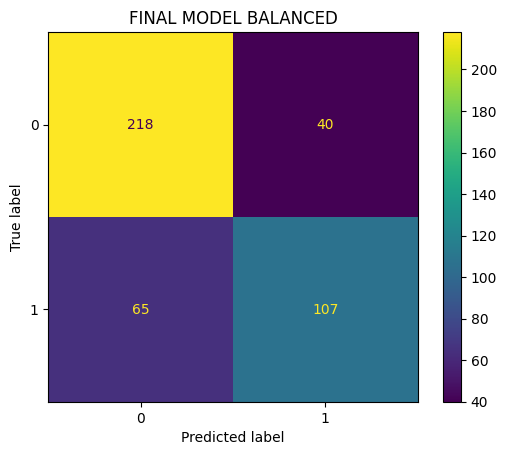

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.7991096271563717
FINAL MODEL IMBALANCED Precision: 0.2767106842737095
FINAL MODEL IMBALANCED Recall: 0.6585714285714286
FINAL MODEL IMBALANCED Specificity: 0.814272503082614
FINAL MODEL IMBALANCED F1 Score: 0.389687235841082


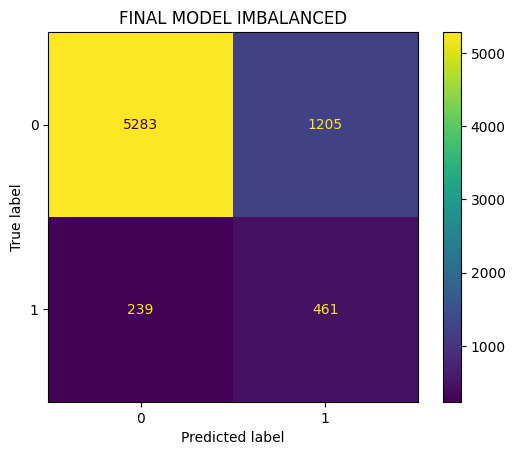

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7186046511627907
FINAL MODEL BALANCED Precision: 0.6335078534031413
FINAL MODEL BALANCED Recall: 0.7034883720930233
FINAL MODEL BALANCED Specificity: 0.7286821705426356
FINAL MODEL BALANCED F1 Score: 0.6666666666666666


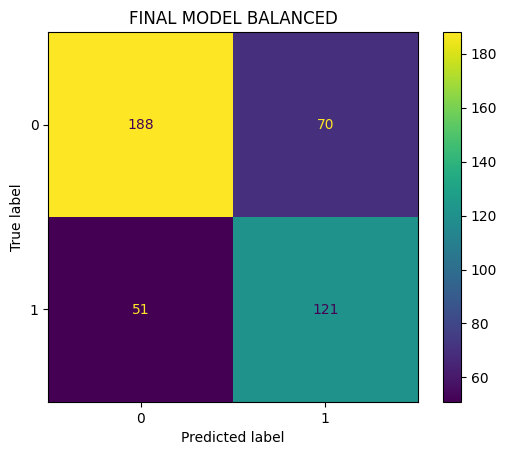

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.7292710072342794
FINAL MODEL IMBALANCED Precision: 0.2281849912739965
FINAL MODEL IMBALANCED Recall: 0.7471428571428571
FINAL MODEL IMBALANCED Specificity: 0.7273427866831073
FINAL MODEL IMBALANCED F1 Score: 0.34959893048128343


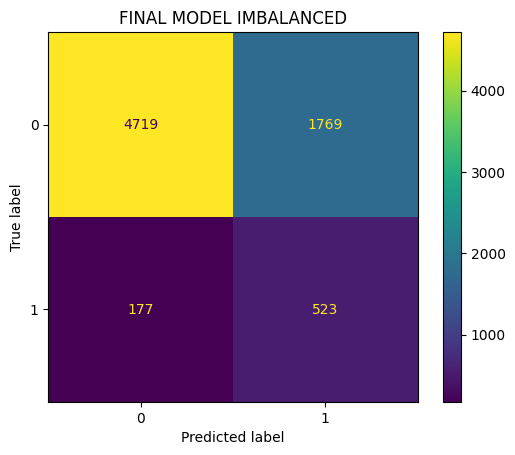

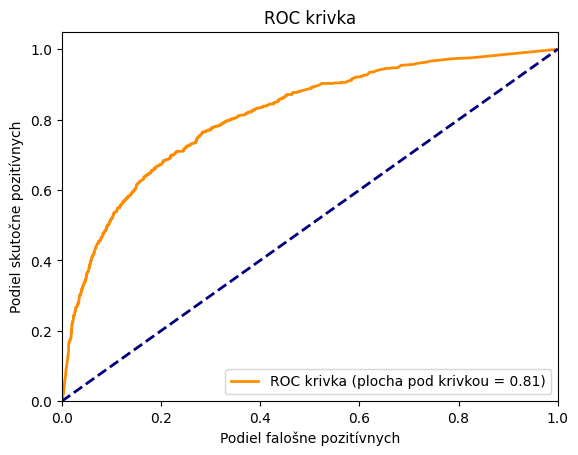

In [9]:


rf_final = (RandomForestClassifier(
    random_state=37,
    max_depth = 5,
    max_features = 'log2',
    criterion = 'gini',
    min_impurity_decrease = 0.01,
    min_samples_leaf = 2,
    min_samples_split = 5,
    n_estimators= 40))

rf_final.fit(X_train_balanced, y_train_balanced)

eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')
eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()


### GBoost

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.772093023255814
FINAL MODEL BALANCED Precision: 0.7720588235294118
FINAL MODEL BALANCED Recall: 0.6104651162790697
FINAL MODEL BALANCED Specificity: 0.8798449612403101
FINAL MODEL BALANCED F1 Score: 0.6818181818181818


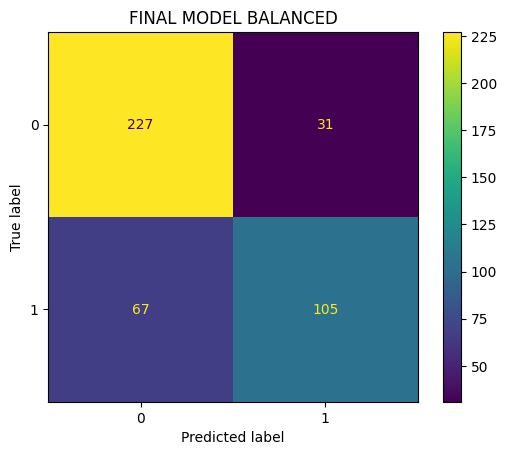

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.8340289371174179
FINAL MODEL IMBALANCED Precision: 0.32677442023893183
FINAL MODEL IMBALANCED Recall: 0.6642857142857143
FINAL MODEL IMBALANCED Specificity: 0.8523427866831073
FINAL MODEL IMBALANCED F1 Score: 0.4380593499764484


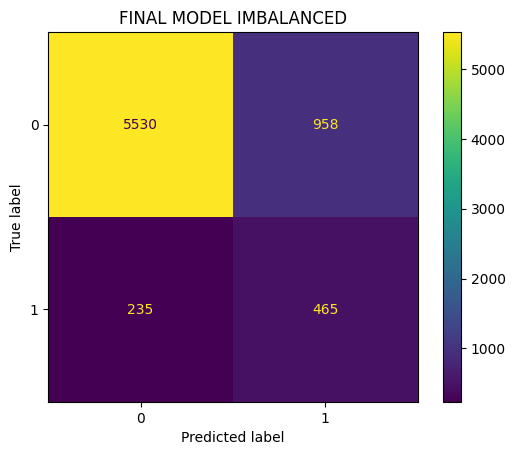

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7558139534883721
FINAL MODEL BALANCED Precision: 0.6892655367231638
FINAL MODEL BALANCED Recall: 0.7093023255813954
FINAL MODEL BALANCED Specificity: 0.7868217054263565
FINAL MODEL BALANCED F1 Score: 0.6991404011461319


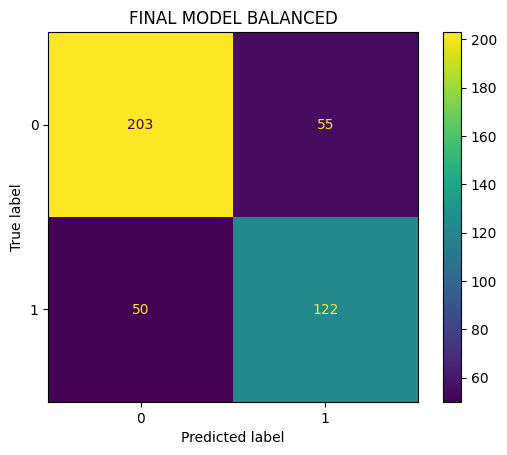

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.7637729549248747
FINAL MODEL IMBALANCED Precision: 0.26009615384615387
FINAL MODEL IMBALANCED Recall: 0.7728571428571429
FINAL MODEL IMBALANCED Specificity: 0.7627928483353884
FINAL MODEL IMBALANCED F1 Score: 0.3892086330935252


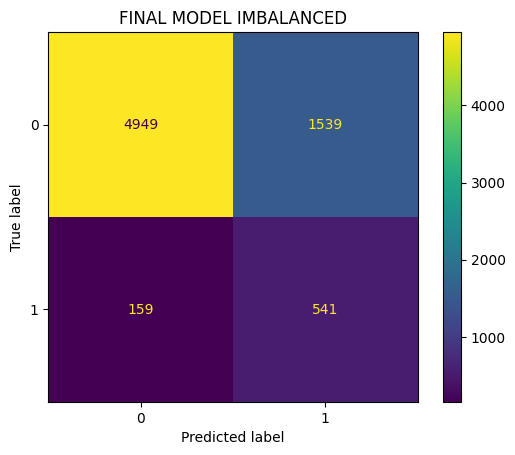

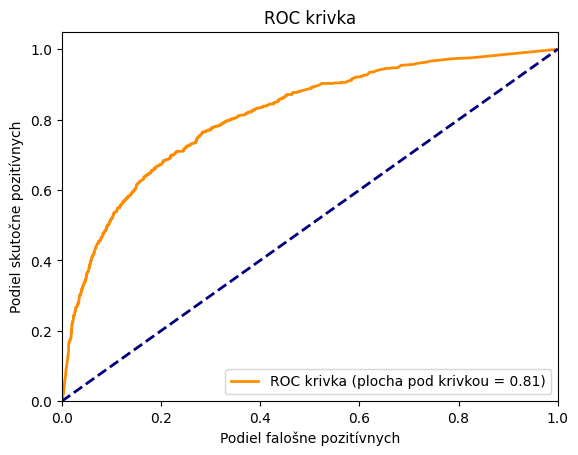

In [10]:


gb_final = GradientBoostingClassifier(
    random_state = 37,
    max_depth= 3,
    min_samples_leaf = 2,
    min_samples_split = 5,
    n_estimators = 30,
    subsample = 0.8
)

gb_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, gb_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, gb_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(gb_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(gb_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()


### SVM

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7604651162790698
FINAL MODEL BALANCED Precision: 0.7555555555555555
FINAL MODEL BALANCED Recall: 0.5930232558139535
FINAL MODEL BALANCED Specificity: 0.872093023255814
FINAL MODEL BALANCED F1 Score: 0.6644951140065146


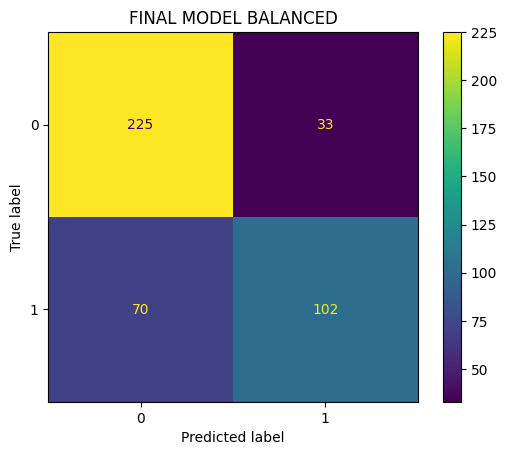

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.830550918196995
FINAL MODEL IMBALANCED Precision: 0.3103953147877013
FINAL MODEL IMBALANCED Recall: 0.6057142857142858
FINAL MODEL IMBALANCED Specificity: 0.8548088779284834
FINAL MODEL IMBALANCED F1 Score: 0.41045498547918685


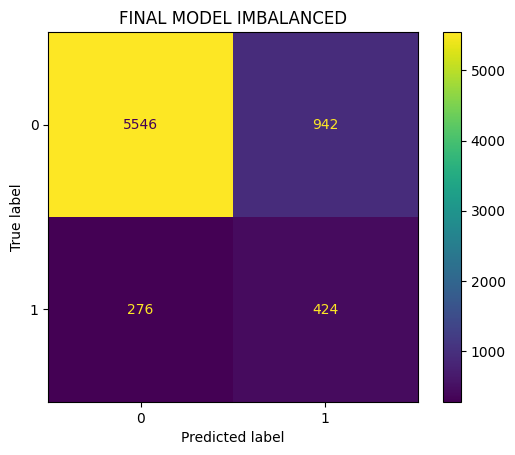

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.6685082872928176
FINAL MODEL BALANCED Recall: 0.7034883720930233
FINAL MODEL BALANCED Specificity: 0.7674418604651163
FINAL MODEL BALANCED F1 Score: 0.6855524079320113


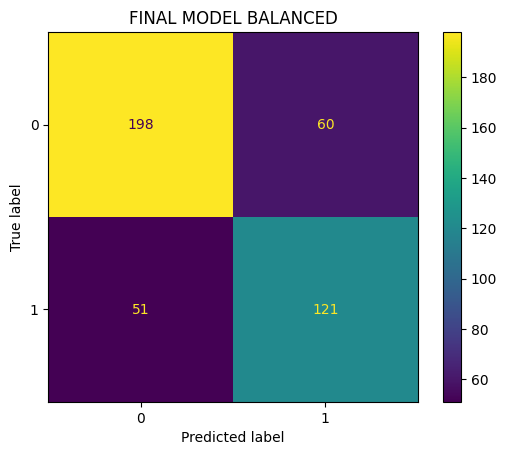

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.7529215358931552
FINAL MODEL IMBALANCED Precision: 0.24405328258801143
FINAL MODEL IMBALANCED Recall: 0.7328571428571429
FINAL MODEL IMBALANCED Specificity: 0.7550863131935882
FINAL MODEL IMBALANCED F1 Score: 0.3661670235546039


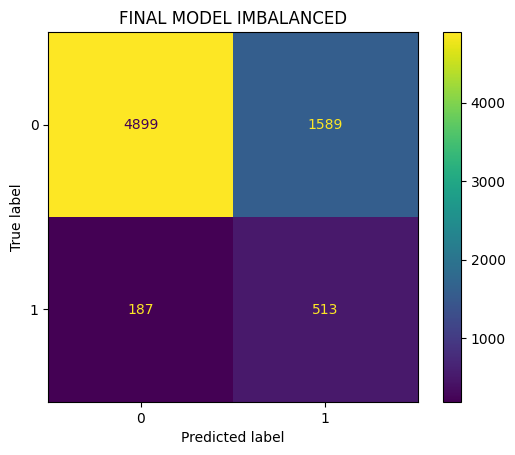

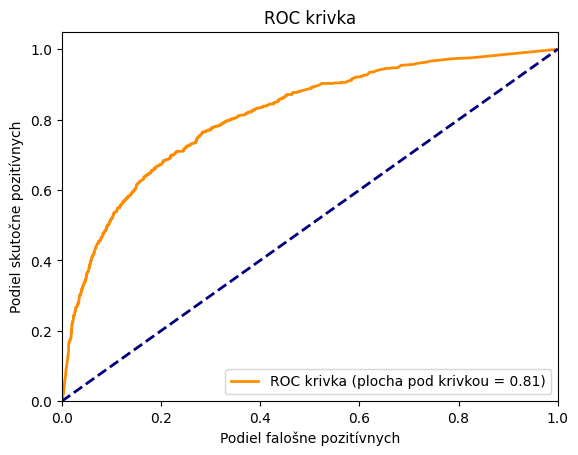

In [11]:
svm_final = SVC(kernel='rbf', random_state=37, C = 10000, gamma=0.001, probability=True)

svm_final.fit(X_train_balanced, y_train_balanced)

eval(y_test_balanced, svm_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, svm_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')

eval(y_test_balanced,predict_w_threshold(svm_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(svm_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()


### MLP

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.7074829931972789
FINAL MODEL BALANCED Recall: 0.6046511627906976
FINAL MODEL BALANCED Specificity: 0.8333333333333334
FINAL MODEL BALANCED F1 Score: 0.6520376175548589


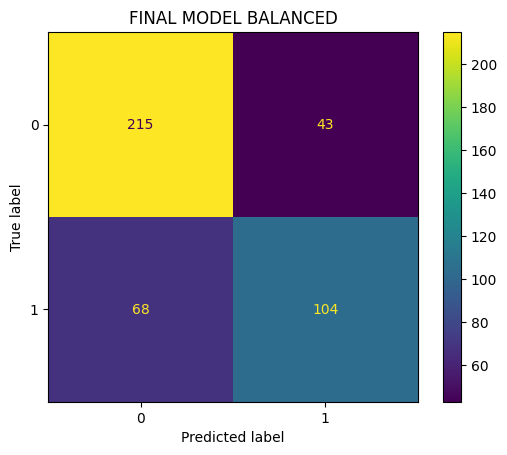

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.8202559821925431
FINAL MODEL IMBALANCED Precision: 0.2975376196990424
FINAL MODEL IMBALANCED Recall: 0.6214285714285714
FINAL MODEL IMBALANCED Specificity: 0.841707768187423
FINAL MODEL IMBALANCED F1 Score: 0.4024051803885291


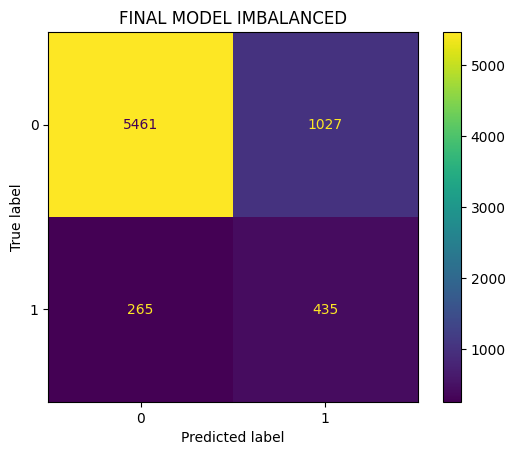

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.6703910614525139
FINAL MODEL BALANCED Recall: 0.6976744186046512
FINAL MODEL BALANCED Specificity: 0.7713178294573644
FINAL MODEL BALANCED F1 Score: 0.6837606837606837


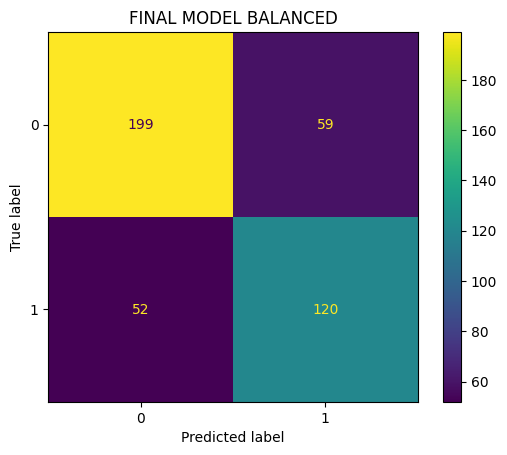

real_positives = 700.0, total = 7188
FINAL MODEL IMBALANCED Accuracy: 0.7545909849749582
FINAL MODEL IMBALANCED Precision: 0.24274661508704062
FINAL MODEL IMBALANCED Recall: 0.7171428571428572
FINAL MODEL IMBALANCED Specificity: 0.7586313193588162
FINAL MODEL IMBALANCED F1 Score: 0.3627167630057804


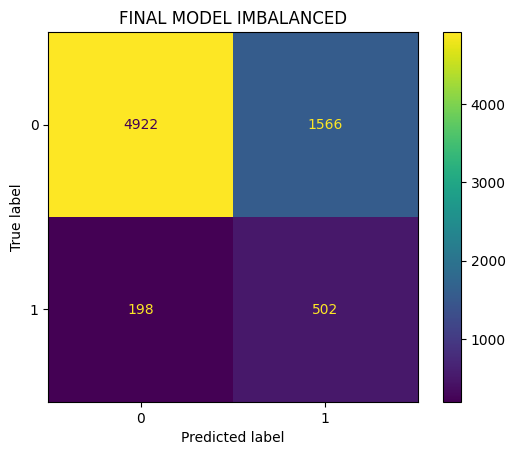

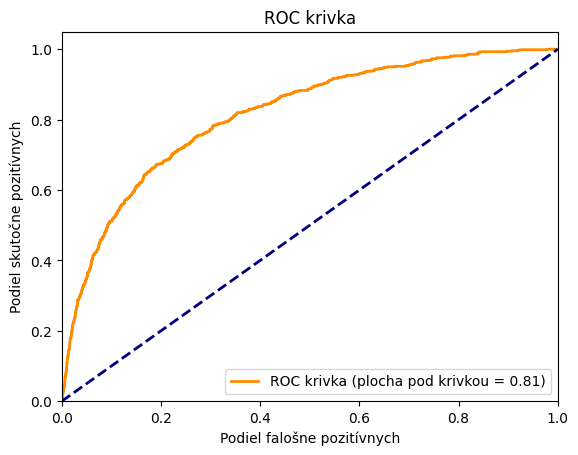

In [12]:
mlp_final = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )

mlp_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, mlp_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, mlp_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(mlp_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(mlp_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

y_probs = mlp_final.predict_proba(X_test_imbalanced)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()


### exporting as objects

In [13]:
# saving classifiers as objects
pickle.dump(rf_final, open('../../../CLASSIFIERS/random_forest_clf', 'wb')) 
pickle.dump(gb_final, open('../../../CLASSIFIERS/xgboost_clf', 'wb')) 
pickle.dump(svm_final, open('../../../CLASSIFIERS/svm_clf', 'wb')) 
pickle.dump(mlp_final, open('../../../CLASSIFIERS/mlp_clf', 'wb')) 


## Summary analysis

In [14]:
test_data = X_test_imbalanced, y_test_imbalanced
train_data = X_train_imbalanced, y_train_imbalanced

rf = pickle.load(open('../../../CLASSIFIERS/random_forest_clf', 'rb')) 
gb = pickle.load(open('../../../CLASSIFIERS/xgboost_clf', 'rb')) 
svm = pickle.load(open('../../../CLASSIFIERS/svm_clf', 'rb')) 
mlp = pickle.load(open('../../../CLASSIFIERS/mlp_clf', 'rb')) 

real_positives = 700.0, total = 7188
RandomForest Accuracy: 0.7991096271563717
RandomForest Precision: 0.2767106842737095
RandomForest Recall: 0.6585714285714286
RandomForest Specificity: 0.814272503082614
RandomForest F1 Score: 0.389687235841082


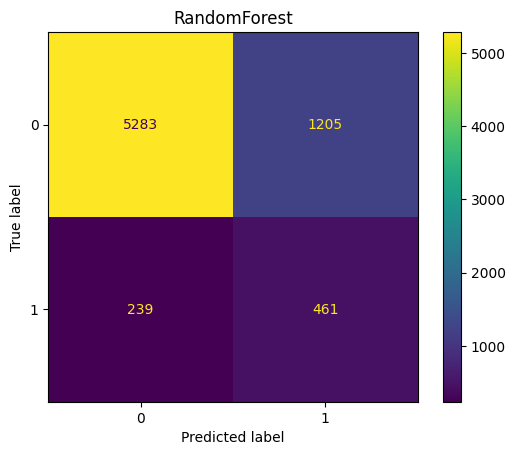

real_positives = 700.0, total = 7188
GBoost Accuracy: 0.8340289371174179
GBoost Precision: 0.32677442023893183
GBoost Recall: 0.6642857142857143
GBoost Specificity: 0.8523427866831073
GBoost F1 Score: 0.4380593499764484


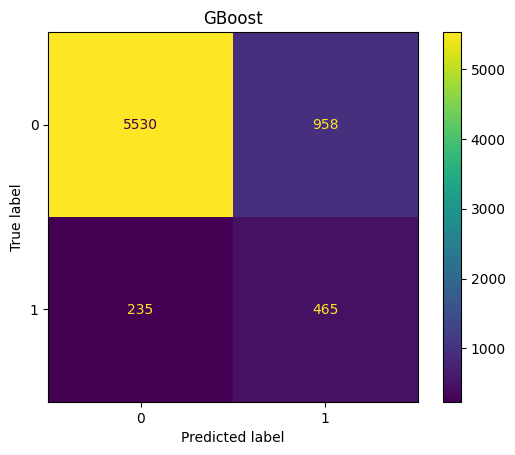

real_positives = 700.0, total = 7188
SupportVectorMachine Accuracy: 0.830550918196995
SupportVectorMachine Precision: 0.3103953147877013
SupportVectorMachine Recall: 0.6057142857142858
SupportVectorMachine Specificity: 0.8548088779284834
SupportVectorMachine F1 Score: 0.41045498547918685


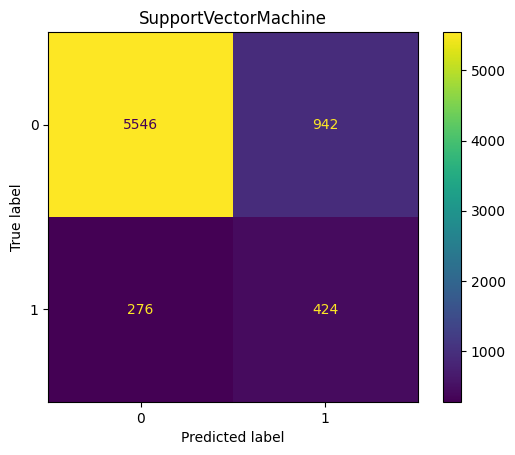

real_positives = 700.0, total = 7188
MLP Accuracy: 0.8202559821925431
MLP Precision: 0.2975376196990424
MLP Recall: 0.6214285714285714
MLP Specificity: 0.841707768187423
MLP F1 Score: 0.4024051803885291


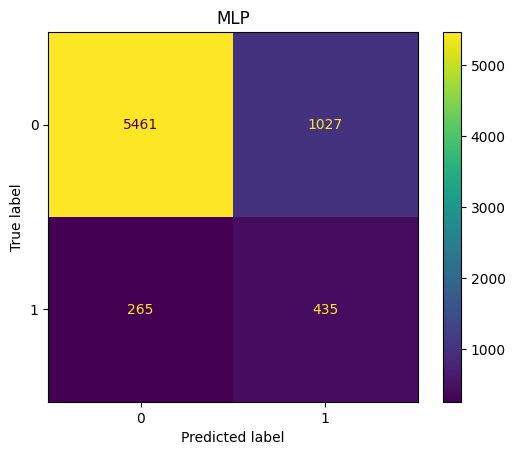

In [16]:
eval(test_data[1], rf.predict(test_data[0]), 'RandomForest')
eval(test_data[1], gb.predict(test_data[0]), 'GBoost')
eval(test_data[1], svm.predict(test_data[0]), 'SupportVectorMachine')
eval(test_data[1], mlp.predict(test_data[0]), 'MLP')

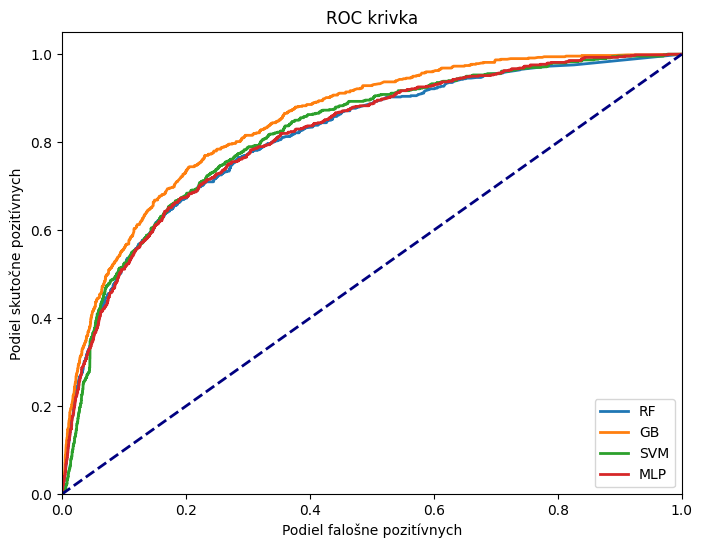

In [17]:
# Compute the ROC curve
rf_roc = roc_curve(test_data[1], rf.predict_proba(test_data[0])[:, 1])
xgb_roc = roc_curve(test_data[1], gb.predict_proba(test_data[0])[:, 1])
svm_roc = roc_curve(test_data[1], svm.predict_proba(test_data[0])[:, 1])
mlp_roc = roc_curve(test_data[1], mlp.predict_proba(test_data[0])[:, 1])

# fpr, tpr, thresholds = roc_curve(test_data[1], rf.predict_proba(test_data[0]))
# fpr, tpr, thresholds = roc_curve(test_data[1], rf.predict_proba(test_data[0]))


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_roc[0], rf_roc[1], lw=2, label=f'RF')
plt.plot(xgb_roc[0], xgb_roc[1], lw=2, label=f'GB')
plt.plot(svm_roc[0], svm_roc[1], lw=2, label=f'SVM')
plt.plot(mlp_roc[0], mlp_roc[1], lw=2, label=f'MLP')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

In [20]:
def eval_proba(x, threshold = 0.5):
    return 1 if x >= threshold else 0


testing_raw['proba_rf'] = rf.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_gb'] = gb.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_svm'] = svm.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_mlp'] = mlp.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]

testing_raw['pred_rf'] = testing_raw['proba_rf'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_gb'] = testing_raw['proba_gb'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_svm'] = testing_raw['proba_svm'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_mlp'] = testing_raw['proba_mlp'].apply(lambda x: eval_proba(x, 0.5))

testing_raw['pred_40_rf'] = testing_raw['proba_rf'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_gb'] = testing_raw['proba_gb'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_svm'] = testing_raw['proba_svm'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_mlp'] = testing_raw['proba_mlp'].apply(lambda x: eval_proba(x, 0.4))

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [21]:
def summary(data, group, real, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')
    all_distressed = data.query(f'{real} == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'all_distressed')
    true_positives_rf = data.query(f'{real} == 1 and {prediction}_rf == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_rf')
    true_positives_xgb = data.query(f'{real} == 1 and {prediction}_gb == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_gb')
    true_positives_svm = data.query(f'{real} == 1 and {prediction}_svm == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_svm')
    true_positives_mlp = data.query(f'{real} == 1 and {prediction}_mlp == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_mlp')

    summary_df = pd.concat(
        [
            all_distressed,
            true_positives_rf,
            true_positives_xgb,
            true_positives_svm,
            true_positives_mlp
        ], axis = 1)
    
    for col in summary_df.columns:
        summary_df[col] = summary_df[col].fillna(0)

    summary_df['tp_ratio_rf'] = (summary_df['true_positives_rf'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_gb'] = (summary_df['true_positives_gb'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_svm'] = (summary_df['true_positives_svm'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_mlp'] = (summary_df['true_positives_mlp'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    
    display(summary_df)

In [22]:
def summary_by_criteria(data, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')

    summary_records = []

    for criteria in ['RUZ_cancelled_3y_off', 'RUZ_indirect_criteria_3y_off', 'combined_issue_criteria_3y_off', 'RU_event_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '50%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_rf == 1')['financial_statement_id'].nunique()
        row['GB'] = data.query(f'{criteria} == 1 and pred_gb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['GB_ratio'] = f"{round(row['GB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)

    
    for criteria in ['combined_issue_criteria_3y_off', 'RUZ_indirect_criteria_3y_off', 'RUZ_cancelled_3y_off', 'RU_event_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '40%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_40_rf == 1')['financial_statement_id'].nunique()
        row['GB'] = data.query(f'{criteria} == 1 and pred_40_gb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_40_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_40_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['GB_ratio'] = f"{round(row['GB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)
    

    summary_df = pd.DataFrame(summary_records)
    
    print(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'GB_ratio', 'SVM_ratio', 'MLP_ratio']].to_latex(index=False))
    
    display(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'GB_ratio', 'SVM_ratio', 'MLP_ratio']])

In [23]:
def summary_by_offset(data, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')

    summary_records = []

    for criteria in ['combined_issue_criteria_1y_off', 'combined_issue_criteria_2y_off', 'combined_issue_criteria_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '50%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_rf == 1')['financial_statement_id'].nunique()
        row['GB'] = data.query(f'{criteria} == 1 and pred_gb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['GB_ratio'] = f"{round(row['GB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)

    
    for criteria in ['combined_issue_criteria_1y_off', 'combined_issue_criteria_2y_off', 'combined_issue_criteria_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '40%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_40_rf == 1')['financial_statement_id'].nunique()
        row['GB'] = data.query(f'{criteria} == 1 and pred_40_gb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_40_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_40_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['GB_ratio'] = f"{round(row['GB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)
    

    summary_df = pd.DataFrame(summary_records)
    
    print(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'GB_ratio', 'SVM_ratio', 'MLP_ratio']].to_latex(index=False))
    
    display(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF',
       'GB', 'SVM', 'MLP']])

In [25]:
summary_by_criteria(testing_raw, 'pred')
summary_by_offset(testing_raw, 'pred')

\begin{tabular}{llrllll}
\toprule
                      Criteria & threshold &  TOTAL & RF\_ratio & GB\_ratio & SVM\_ratio & MLP\_ratio \\
\midrule
          RUZ\_cancelled\_3y\_off &       50\% &     21 &    0.43\% &    0.52\% &     0.57\% &     0.29\% \\
  RUZ\_indirect\_criteria\_3y\_off &       50\% &    135 &     0.7\% &    0.69\% &     0.59\% &     0.68\% \\
combined\_issue\_criteria\_3y\_off &       50\% &    172 &    0.62\% &    0.61\% &     0.55\% &      0.6\% \\
               RU\_event\_3y\_off &       50\% &     39 &    0.46\% &    0.44\% &     0.44\% &     0.49\% \\
combined\_issue\_criteria\_3y\_off &       40\% &    172 &     0.7\% &    0.71\% &      0.7\% &      0.7\% \\
  RUZ\_indirect\_criteria\_3y\_off &       40\% &    135 &    0.77\% &    0.79\% &     0.76\% &     0.77\% \\
          RUZ\_cancelled\_3y\_off &       40\% &     21 &    0.52\% &    0.57\% &     0.67\% &     0.43\% \\
               RU\_event\_3y\_off &       40\% &     39 &    0.56\% &    0.56\% &    

,Criteria,threshold,TOTAL,RF_ratio,GB_ratio,SVM_ratio,MLP_ratio
0,RUZ_cancelled_3y_off,50%,21,0.43%,0.52%,0.57%,0.29%
1,RUZ_indirect_criteria_3y_off,50%,135,0.7%,0.69%,0.59%,0.68%
2,combined_issue_criteria_3y_off,50%,172,0.62%,0.61%,0.55%,0.6%
3,RU_event_3y_off,50%,39,0.46%,0.44%,0.44%,0.49%
4,combined_issue_criteria_3y_off,40%,172,0.7%,0.71%,0.7%,0.7%
5,RUZ_indirect_criteria_3y_off,40%,135,0.77%,0.79%,0.76%,0.77%
6,RUZ_cancelled_3y_off,40%,21,0.52%,0.57%,0.67%,0.43%
7,RU_event_3y_off,40%,39,0.56%,0.56%,0.54%,0.56%


\begin{tabular}{llrllll}
\toprule
                      Criteria & threshold &  TOTAL & RF\_ratio & GB\_ratio & SVM\_ratio & MLP\_ratio \\
\midrule
combined\_issue\_criteria\_1y\_off &       50\% &     68 &    0.84\% &    0.87\% &     0.74\% &     0.79\% \\
combined\_issue\_criteria\_2y\_off &       50\% &    113 &    0.71\% &    0.71\% &     0.59\% &      0.7\% \\
combined\_issue\_criteria\_3y\_off &       50\% &    172 &    0.62\% &    0.61\% &     0.55\% &      0.6\% \\
combined\_issue\_criteria\_1y\_off &       40\% &     68 &    0.93\% &    0.93\% &     0.87\% &     0.85\% \\
combined\_issue\_criteria\_2y\_off &       40\% &    113 &    0.79\% &     0.8\% &     0.76\% &     0.78\% \\
combined\_issue\_criteria\_3y\_off &       40\% &    172 &     0.7\% &    0.71\% &      0.7\% &      0.7\% \\
\bottomrule
\end{tabular}



,Criteria,threshold,TOTAL,RF,GB,SVM,MLP
0,combined_issue_criteria_1y_off,50%,68,57,59,50,54
1,combined_issue_criteria_2y_off,50%,113,80,80,67,79
2,combined_issue_criteria_3y_off,50%,172,107,105,95,104
3,combined_issue_criteria_1y_off,40%,68,63,63,59,58
4,combined_issue_criteria_2y_off,40%,113,89,90,86,88
5,combined_issue_criteria_3y_off,40%,172,121,122,121,120


In [26]:
pd.concat(
    [
        testing_raw.groupby(['pred_rf', 'pred_xgb', 'pred_svm', 'pred_mlp'])['financial_statement_id'].nunique().to_frame('total'),
        testing_raw.query('combined_issue_criteria_3y_off == 1').groupby(['pred_rf', 'pred_xgb', 'pred_svm', 'pred_mlp'])['financial_statement_id'].nunique().to_frame('distressed'),
    ], axis = 1
).reset_index()



,pred_rf,pred_xgb,pred_svm,pred_mlp,total,distressed
0,0,0,0,0,1286,48.0
1,0,0,0,1,24,6.0
2,0,0,1,0,32,3.0
3,0,0,1,1,12,3.0
4,0,1,0,0,19,2.0
5,0,1,0,1,4,NaN
6,0,1,1,0,1,1.0
7,0,1,1,1,4,2.0
8,1,0,0,0,40,2.0
9,1,0,0,1,24,3.0


real_positives = 172.0, total = 1797
RandomForest Accuracy: 0.8074568725653868
RandomForest Precision: 0.2803030303030303
RandomForest Recall: 0.6453488372093024
RandomForest Specificity: 0.8246153846153846
RandomForest F1 Score: 0.3908450704225352


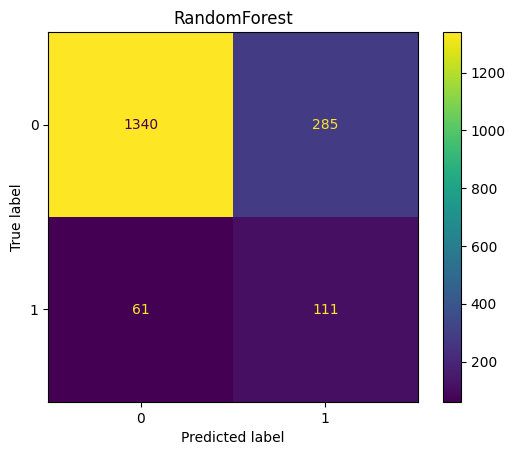

In [27]:
testing_raw['pred_avg'] = (testing_raw['pred_rf'] + testing_raw['pred_xgb'] + testing_raw['pred_svm'] + testing_raw['pred_mlp']).apply(lambda x: 1 if x > 1 else 0)


# testing_raw['pred_avg'] = testing_raw['proba_avg'].apply(lambda x: eval_proba(x, 0.5))
# testing_raw['pred_40_avg'] = testing_raw['proba_avg'].apply(lambda x: eval_proba(x, 0.4))

eval(testing_raw['combined_issue_criteria_3y_off'], testing_raw['pred_avg'], 'RandomForest')